## Data Ingestion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Grab the data
try:
    # From apple.com
    url_data = "https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev46/v2/en-us/applemobilitytrends-2020-05-03.csv"
    df = pd.read_csv(url_data)
except:
    # URL is broken, so use data from May 2, 2020
    df = pd.read_csv("data/mobility_data.csv")
df.head()

,geo_type,region,transportation_type,alternative_name,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,...,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02
0,country/region,Albania,driving,NaN,100.0,95.30,101.43,97.20,103.55,112.67,...,33.94,30.22,25.22,30.39,37.39,36.69,35.90,38.09,37.23,29.36
1,country/region,Albania,walking,NaN,100.0,100.68,98.93,98.46,100.85,100.13,...,34.80,34.63,29.00,35.22,41.83,37.53,41.49,38.25,38.68,32.28
2,country/region,Argentina,driving,NaN,100.0,97.07,102.45,111.21,118.45,124.01,...,28.73,30.99,25.92,16.57,27.45,27.12,32.22,34.45,22.69,28.23
3,country/region,Argentina,walking,NaN,100.0,95.11,101.37,112.67,116.72,114.14,...,20.39,22.32,23.31,16.36,18.48,17.49,22.78,24.80,16.62,20.61
4,country/region,Australia,driving,NaN,100.0,102.98,104.21,108.63,109.08,89.00,...,62.87,47.84,41.89,55.39,59.09,59.46,59.46,63.12,58.40,48.67


In [3]:
# Grab the different region names for use in the interactive dropdown menu
region_options = df["region"].unique().tolist()

In [4]:
# Visually inspect information for just one city
austin = df.loc[df['region'] == 'Austin']
austin_driving = austin.loc[df['transportation_type'] == "driving"]
austin_walking = austin.loc[df['transportation_type'] == "walking"]
austin_transit = austin.loc[df['transportation_type'] == "transit"]

# Get just the driving requests from that city
austin_driving_data = austin_driving.iloc[:,4:]
data = austin_driving_data.iloc[0] - 100
dates = austin_driving_data.columns

## Make an interactive plot using Bokeh

In [5]:
from bokeh.io import show, output_notebook, curdoc, push_notebook
from bokeh.plotting import figure
from ipywidgets import interact
from bokeh.layouts import row, column, widgetbox, gridplot
from bokeh.models import ColumnDataSource, Legend, LegendItem, CheckboxGroup
from bokeh.models.widgets import Slider, TextInput, Button, Paragraph, Select
from bokeh.models.annotations import Title

output_notebook()

Loading BokehJS ...

In [6]:
def modify_doc(doc):

    # Use Austin driving data to start
    austin = df.loc[df['region'] == 'Austin']
    austin_driving = austin.loc[df['transportation_type'] == "driving"]
    austin_driving_data = austin_driving.iloc[:,4:]
    data = austin_driving_data.iloc[0] - 100

    y1 = list(data.values)
    x = pd.to_datetime(data.index.values)
    y2 = [0]* len(y1)
    y3 = [0]* len(y1)

    source = ColumnDataSource(data=dict(x=x, y1=y1, y2=y2, y3=y3, y4=[0]* len(y1)))

    TOOLS = 'tap'
    plot = figure(plot_width=600, plot_height=500, tools=TOOLS, toolbar_location=None, title='Apple Maps Routing Requests: Austin', x_axis_type="datetime")
    
    plot1 = plot.line(x='x', y='y1', source=source, line_width=2, color='#9441f2')
    plot2 = plot.line(x='x', y='y2', source=source, line_width=2, color='#b1f241')
    plot3 = plot.line(x='x', y='y3', source=source, line_width=2, color='#4287f5')
    plot4 = plot.line(x='x', y='y4', source=source, line_width=2, color='black')
    
    legend_items = [LegendItem(label="Driving", renderers=[plot1]),
                    LegendItem(label="Transit", renderers=[plot2]),
                    LegendItem(label="Walking", renderers=[plot3]),
                    LegendItem(label="Baseline", renderers=[plot4])]
    plot.add_layout(Legend(items=legend_items))
    plot.yaxis.axis_label = "Percent Change in Routing Requests"
    
    # Set up widgets
    # text = TextInput(title="Title", value='Profit')
    region = Select(title="Region", value="Austin", options=region_options)
    request_type = Select(title="Request Type", value="driving", options=["all", "transit", "walking", "driving"])
    info = Paragraph(text="Select a region to view its mobility data over time. **Note: Not all regions have transit, walking, and driving data available")

    
    # Set up callbacks
    def update_request_type(attrname, old, new):
        # Get the current select value
        a = request_type.value
        b = region.value
        
        regional_data = df.loc[df['region'] == b]
        
        # Change the data source
        if a == "driving":
            y1subset = regional_data.loc[df['transportation_type'] == "driving"]
            driving_data = y1subset.iloc[:,4:]
            y1subset = driving_data.iloc[0] - 100
            source.data = dict(x=x, y1=y1subset, y2=[0]* len(x), y3=[0]* len(x), y4=[0]* len(x))
            
        elif a == "transit":
            y2subset = regional_data.loc[df['transportation_type'] == "transit"]
            transit_data = y2subset.iloc[:,4:]
            y2subset = transit_data.iloc[0] - 100
            source.data = dict(x=x, y1=[0]* len(x), y2=y2subset, y3=[0]* len(x), y4=[0]* len(x))

        elif a == "walking":   
            y3subset = regional_data.loc[df['transportation_type'] == "walking"]
            walking_data = y3subset.iloc[:,4:]
            y3subset = walking_data.iloc[0] - 100
            source.data = dict(x=x, y1=[0]* len(x), y2=[0]* len(x), y3=y3subset, y4=[0]* len(x))

        elif a == "all":
            y1subset = regional_data.loc[df['transportation_type'] == "driving"]
            driving_data = y1subset.iloc[:,4:]
            y1subset = driving_data.iloc[0] - 100
            
            if (regional_data.loc[df['transportation_type'] == "transit"].empty == True):
                y2subset = [0]* len(x)
            else:
                y2subset = regional_data.loc[df['transportation_type'] == "transit"]
                transit_data = y2subset.iloc[:,4:]
                y2subset = transit_data.iloc[0] - 100
            
            y3subset = regional_data.loc[df['transportation_type'] == "walking"]
            walking_data = y3subset.iloc[:,4:]
            y3subset = walking_data.iloc[0] - 100
            
            source.data = dict(x=x, y1=y1subset, y2=y2subset, y3=y3subset, y4=[0]* len(x)) 
    request_type.on_change('value', update_request_type)
    
    def update_region(attrname, old, new):
        # Get the current select value
        a = region.value
        # Generate the new source
        regional_data = df.loc[df['region'] == a]     
        regional_driving = regional_data.loc[df['transportation_type'] == "driving"]
        request_type.value = "driving"
        request_type.options = regional_data.transportation_type.unique().tolist() + ["all"]
        t = Title()
        t.text = "Apple Maps Routing Requests: " + a
        plot.title.text = "Apple Maps Routing Requests: " + a

        # Get just the numbers from that region
        regional_driving_data = regional_driving.iloc[:,4:]
        regional_data = regional_driving_data.iloc[0] - 100
        
        y1subset = regional_data
        source.data = dict(x=x, y1=y1subset, y2=[0]* len(x), y3=[0]* len(x), y4=[0]* len(x))
    region.on_change('value', update_region)

    # Set up layouts and add to document
    inputs = widgetbox(info, region, request_type)
    layout = row(inputs,plot, width=700)
    doc.add_root(layout)

show(modify_doc, notebook_url="http://localhost:8888")

### Make a plot to compare countries

In [7]:
# Take the average of driving/walking/transit data for each country of interest
date_columns = df.columns[4:].values.tolist()
country_means = {}
countries = ["United States", "Germany", "UK", "Italy"]
for country in countries:
    country_data = df.loc[df['region'] == country]
    means_list = []
    for date in date_columns:
        means_list.append(country_data[date].mean() - 100)
    country_means[country] = means_list

In [9]:
def modify_doc(doc):

    # First graph render uses only USA data and a baseline
    x = pd.to_datetime(df.columns[4:].values)
    y1 = country_means["United States"]
    y2 = [0]*len(x) #germany_means
    y3 = [0]*len(x) #uk_means
    y4 = [0]*len(x) #italy_means

    source = ColumnDataSource(data=dict(x=x, y1=y1, y2=y2, y3=y3, y4=y4, y5=[0]*len(x)))

    TOOLS = 'tap'
    plot = figure(plot_width=600, plot_height=500, tools=TOOLS, toolbar_location=None, title='Apple Maps Routing Requests: Countries', x_axis_type="datetime")
    plot.yaxis.axis_label = "Percent Change in Routing Requests"
    
    plot.line(x='x', y='y1', source=source, line_width=2, color='red', legend_label="USA")
    plot.line(x='x', y='y2', source=source, line_width=2, color='purple', legend_label="Germany")
    plot.line(x='x', y='y3', source=source, line_width=2, color='orange', legend_label="UK")
    plot.line(x='x', y='y4', source=source, line_width=2, color='green', legend_label="Italy")
    plot.line(x='x', y='y5', source=source, line_width=2, color='black', legend_label="Baseline")
    
    # Set up widgets
    checkboxes = CheckboxGroup(
        labels=["United States", "Germany", "United Kingdom", "Italy"], active=[0])
    info = Paragraph(text="Select a region to view its mobility data over time. **Note: Not all regions have transit, walking, and driving data available")

    # Set up callbacks
    def update_graph(attrname, old, new):
        # Get the current select value
        a = checkboxes.active
        y1subset, y2subset, y3subset, y4subset = [0]*len(x), [0]*len(x), [0]*len(x), [0]*len(x)
        if 0 in a:
            y1subset = country_means["United States"]
        if 1 in a:
            y2subset = country_means["Germany"]
        if 2 in a:
            y3subset = country_means["UK"]
        if 3 in a:
            y4subset = country_means["Italy"]
        
        source.data = dict(x=x, y1=y1subset, y2=y2subset, y3=y3subset, y4=y4subset, y5=[0]*len(x))
    checkboxes.on_change('active', update_graph)

    # Set up layouts and add to document
    inputs = widgetbox(info, checkboxes)
    layout = row(inputs,plot, width=700)
    doc.add_root(layout)

show(modify_doc, notebook_url="http://localhost:8888")

## Non-interactive plot 

In [12]:
# Get the values for the xtick marks
date_values = dates.values
month_indices = {"JAN 13":0}
month_names = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
          'AUG', 'SEPT', 'OCT', 'NOV', 'DEC']
new_month = "01"
index = 0
for date in date_values:
    month = date.split("-")[1]
    if month[0] == "0":
        month_index = month[1]
    else:
        month_index = month
    
    if month != new_month:
        month_indices[month_names[int(month_index)-1]] = index
        new_month = month = date.split("-")[1]
    index += 1

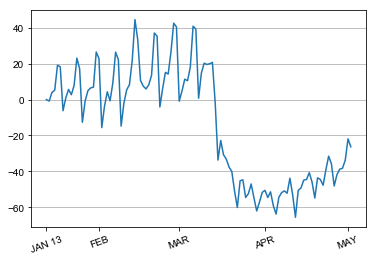

In [13]:
plt.plot(dates, data)
plt.style.use("seaborn")
plt.xticks(list(month_indices.values()), list(month_indices.keys()), rotation=20)
plt.grid(b=True, which='major', axis='y')
plt.grid(b=False, which='major', axis='x')